# Import Libraries

In [8]:
import pandas as pd
import numpy as np

from pathlib import Path

import urllib

import rioxarray # for the extension to load
import xarray
import rasterio
import geopandas as gpd
import xrspatial as xrs
from rasterstats import zonal_stats
import rasterstats
import platform
import requests
import sys
import datetime
import os

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import pyproj
from pyproj import Proj
#import simplekml

import netCDF4


In [9]:
pyproj.datadir.get_data_dir()



'C:\\Users\\kladig\\AppData\\Local\\anaconda3\\envs\\pygis12v2\\Library\\share\\proj'

In [10]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 11
Python Version 3.12.6 | packaged by conda-forge | (main, Sep 30 2024, 17:48:58) [MSC v.1941 64 bit (AMD64)]
Pandas Version 2.2.2
Numpy Version 2.0.2
Matplotlib Version 3.9.2
pygis12v2


# Import Data

In [11]:
#zones_bounds = gpd.read_file(r"D:\milford\SWB\AOI\milford_study_area.shp")

zones_basin = gpd.read_file(r"D:\milford\SWB\AOI\ETPolygons_5070.shp")#, driver='FileGDB', layer="ETPolygons_5070")
#zones_basin = gpd.read_file(r"D:\milford\SWB\AOI\Milford_Aquifer_FansSeparate_5070.shp")#, driver='FileGDB', layer="Milford_Aquifer_FansSeparate_5070")
#zones_basin = gpd.read_file(r"D:\milford\SWB\AOI\Milford_Aquifer_5070.shp")


#zone_da = rioxarray.open_rasterio(r"G:\Shared drives\UGS_Groundwater\Projects\Bryce\GIS\bounds_simp.tif")

# Group By Water Year

https://stackoverflow.com/questions/72268056/python-adding-a-water-year-time-variable-in-an-x-array

C:\Users\kladig\AppData\Local\Temp\ipykernel_18872\1066129114.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i in range(len(g.axes[0,:])):
C:\Users\kladig\AppData\Local\Temp\ipykernel_18872\1066129114.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zones_basin.geometry.boundary.plot(ax = g.axes[0,i], color=None,edgecolor='k')
C:\Users\kladig\AppData\Local\Temp\ipykernel_18872\1066129114.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zones_basin.geometry.boundary.plot(ax = g.axes[0,i], color=None,edgecolor='k')
C:\Users\kladig\AppData\Local\Temp\ipykernel_18872\1066129114.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zones_ba

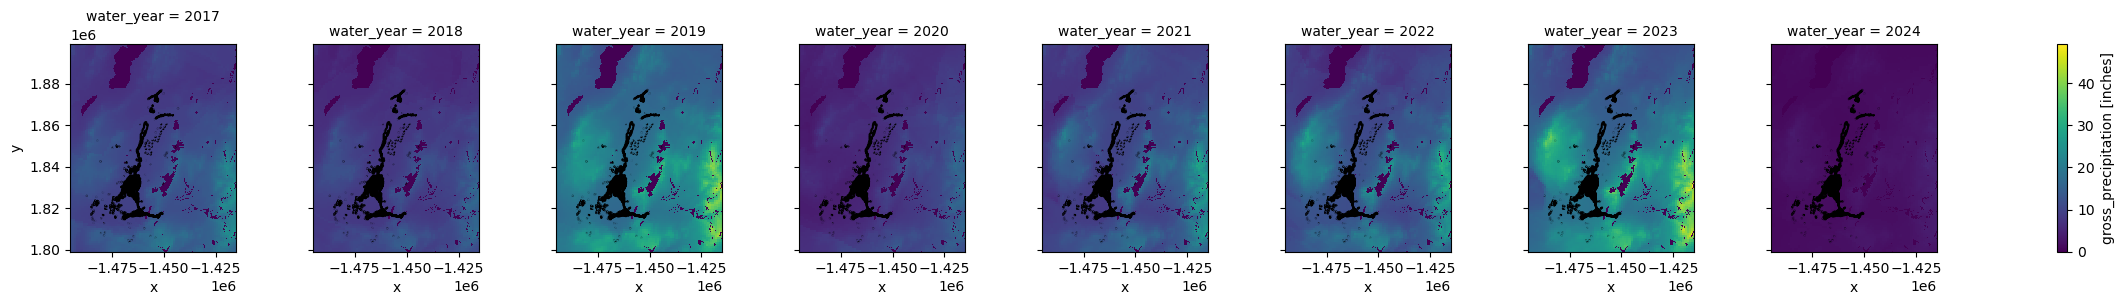

In [12]:
parameter = 'gross_precipitation'
dst = f"{parameter}__2017-01-01_to_2023-12-31__1000_by_800.nc"
xds = xarray.open_dataset(dst, decode_coords="all")

water_year = (xds.time.dt.month >= 10) + xds.time.dt.year
xds.coords['water_year'] = water_year
xds_wy = xds.groupby('water_year', restore_coord_dims=True).sum(dim='time')

g = xds_wy[parameter].plot(col='water_year')
for i in range(len(g.axes[0,:])):
    zones_basin.geometry.boundary.plot(ax = g.axes[0,i], color=None,edgecolor='k')
plt.show()


# Zonal Statistics

* https://gis.stackexchange.com/questions/177035/using-geopandas-with-rasterstats-for-zonal-statistic-gives-error
* https://automating-gis-processes.github.io/CSC/notebooks/L5/zonal-statistics.html

In [6]:
help(rasterstats.gen_zonal_stats)

Help on function gen_zonal_stats in module rasterstats.main:

gen_zonal_stats(vectors, raster, layer=0, band=1, nodata=None, affine=None, stats=None, all_touched=False, categorical=False, category_map=None, add_stats=None, zone_func=None, raster_out=False, prefix=None, geojson_out=False, boundless=True, **kwargs)
    Zonal statistics of raster values aggregated to vector geometries.

    Parameters
    ----------
    vectors: path to an vector source or geo-like python objects

    raster: ndarray or path to a GDAL raster source
        If ndarray is passed, the ``affine`` kwarg is required.

    layer: int or string, optional
        If `vectors` is a path to a fiona source,
        specify the vector layer to use either by name or number.
        defaults to 0

    band: int, optional
        If `raster` is a GDAL source, the band number to use (counting from 1).
        defaults to 1.

    nodata: float, optional
        If `raster` is a GDAL source, this value overrides any NODATA 

In [7]:
help(to_raster)

NameError: name 'to_raster' is not defined

In [ ]:
rast = {}


#dfs_bounds = {}
dfs_basin = {}

parameters = ['gross_precipitation','actual_et','interception','rainfall','reference_ET0','irrigation','net_infiltration','rejected_net_infiltration','runoff','runon','snowfall','runoff_outside']

for parameter in parameters:              
    dst = f"{parameter}__2017-01-01_to_2023-12-31__1000_by_800.nc"
    xds = xarray.open_dataset(dst, decode_coords="all")
    water_year = (xds.time.dt.month >= 10) + xds.time.dt.year
    xds.coords['water_year'] = water_year
    xds_wy = xds.groupby('water_year', restore_coord_dims=True).sum(dim='time')

    xds_wy.to_netcdf(f"{parameter}_wy_2017-01-01_to_2023-12-31__1000_by_800.nc")

    #yr_total_bounds = {}
    yr_total_basin = {}
    
    print(parameter)
    for wy in range(2017,2024):
        print(wy)
        rasterfile = f"./rasters/{parameter}_{wy}.tif"
        path = Path(rasterfile)
        if path.is_file():
            pass
        else:
            xds_wy[parameter].sel(water_year = wy).rio.to_raster(rasterfile) #.write_crs("epsg:6350")
        rast[f"{parameter}{wy}"] = rasterio.open(rasterfile)
        # Read the raster values
        array = rast[f"{parameter}{wy}"].read(1)

        # Get the affine
        affine = rast[f"{parameter}{wy}"].transform

        rast[f"{parameter}{wy}"].close()

        #zs_bounds = zonal_stats(zones_bounds, array, affine=affine, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']
        zs_basin = zonal_stats(zones_basin, array, affine=affine, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']

        #total_bounds = {}
        #for i in range(len(zones_bounds.geometry.area)):
        #    area_bounds = zones_bounds.geometry.area[i]
        #    p_meas_bounds = zs_bounds[i]['mean']*0.0254 # in to meters
        #    total_bounds[zones_bounds.loc[i,'Name']] = area_bounds*p_meas_bounds*0.000810714
        
        #total_basin = {}
        #for i in range(len(zones_basin.geometry.area)):
         #   area_basin = zones_basin.geometry.area[i]
          #  p_meas_basin = zs_basin[i]['mean']*0.0254 # in to meters
           # total_basin[zones_basin.loc[i,'Zone']] = area_basin*p_meas_basin*0.000810714


        ## The above two sections of code work well most of the time.  I encountered a data type error, which the code below addresses. -KL

        for i in range(len(zones_basin.geometry.area)):
            area_basin = zones_basin.geometry.area[i]
            p_meas_basin = zs_basin[i]['mean'] 
            if p_meas_basin is None: 
                # Handle the case where p_meas_basin is None
                total_basin[zones_basin.loc[i,'Zone']] = 0  # or any other appropriate value
            else:
                p_meas_basin = p_meas_basin * 0.0254  # in to meters
                total_basin[zones_basin.loc[i,'Zone']] = area_basin * p_meas_basin * 0.000810714

            
       # yr_total_bounds[wy] = total_bounds
        yr_total_basin[wy] = total_basin

   # dfs_bounds[f"{parameter}"] = pd.DataFrame(yr_total_bounds)
    dfs_basin[f"{parameter}"] = pd.DataFrame(yr_total_basin)
    


gross_precipitation
2017
2018
2019
2020
2021
2022
2023
actual_et
2017
2018
2019
2020
2021
2022
2023
interception
2017
2018
2019
2020
2021
2022
2023
rainfall
2017
2018
2019
2020
2021
2022
2023
reference_ET0
2017
2018
2019
2020
2021
2022
2023
irrigation
2017
2018
2019
2020
2021
2022
2023
net_infiltration
2017
2018
2019
2020
2021
2022
2023
rejected_net_infiltration
2017
2018
2019
2020
2021
2022
2023
runoff
2017
2018
2019
2020
2021
2022
2023
runon
2017
2018
2019
2020
2021
2022
2023
snowfall
2017


In [ ]:
print(range(len(zones_basin.geometry.area)))

In [ ]:
#pd.concat(dfs_bounds).T.to_clipboard()

In [ ]:
pd.concat(dfs_basin).T.to_clipboard()

In [ ]:
	gross_precipitation	gross_precipitation	actual_et	actual_et	interception	interception	rainfall	rainfall	reference_ET0	reference_ET0	irrigation	irrigation	net_infiltration	net_infiltration	rejected_net_infiltration	rejected_net_infiltration	runoff	runoff	runon	runon	snowfall	snowfall	runoff_outside	runoff_outside
	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford	Beaver	Milford
2017	38467.865331798734	300101.0763488293	74333.97579730276	483126.37291892694	448.9309246997013	1330.2679674435954	29984.15743374409	245934.77363115433	131886.84274539462	1443543.4369184119	24639.32370809714	61753.05464855256	4839.981687835286	44003.08847702516	6118.395386498855	32935.56570768264	2653.8316416059183	23359.738202827823	0.0	0.0	8483.706289797447	54166.334895579756	8772.226827072624	56295.29586603428
2018	27287.775930406362	253304.74945323024	57078.585467237164	337149.06838324846	418.94049626907616	1294.6893609278445	20859.542959531038	184851.45702115932	154533.65157911778	1677156.5700310713	30430.078907161176	73297.35421496542	2118.357582606972	3083.585485488073	2004.0895014313198	1696.764850424994	278.63005705286946	1771.4145727946175	0.0	0.0	6428.233372939622	68453.3246099757	2282.7194579681145	3468.179624331516
2019	63754.51256227613	567837.7705418279	78915.1671904336	597531.1806638095	715.864328180319	2344.9159393490413	49929.08452451076	456587.73606447456	140637.03564471973	1522786.9590255376	25603.4545994877	62704.28499796942	4344.912678561856	11884.190752177392	4415.8601407433325	8038.9423953667765	2746.837356425026	11465.401757278923	0.0	0.0	13825.424821250981	111250.03447735343	7162.697497168358	19504.344152645695
2020	27150.61089046408	178500.2851485008	55630.980296845475	254695.24681613623	334.7891168431475	1016.9429604066544	14153.805209061393	96801.99434962294	153345.44542878013	1663702.6019151579	31690.540836911227	76091.4260412727	2491.150193985016	2919.583553839189	2213.2453604125776	1047.6462121271295	997.0402563783509	489.29359979901255	0.0	0.0	12996.808897917083	81698.31010562072	3210.285817823078	1536.9399124820943
2021	34849.43459492536	317363.3381068292	60206.80011093346	365334.132783923	466.03438819906427	1558.0753658894002	20024.923412075288	181121.4843992639	153815.33958399747	1670893.565617461	29098.287554145005	72292.1679548434	2121.2622961395405	2791.923951164395	1609.883045971851	1326.1072638018966	768.2519997111889	12374.94965331451	0.0	0.0	14824.51118285007	136241.89232105098	2378.134945166965	13701.059028791407
2022	37272.26119834819	396905.47117014753	61453.443894834345	443839.0561363001	506.57734597934916	1836.2136329570221	24418.884718675785	296099.63805119845	151920.31082796532	1640228.6916795482	28446.441612522674	68225.08673149774	2549.328094010718	7176.375044731551	2646.2712245159564	5191.519200740048	660.1399752849811	9391.19631846292	0.0	0.0	12853.374067286604	100805.88460359669	3306.4111495428997	14582.719139217259
2023	62150.25027469683	574641.4667247377	77338.17451191138	571813.2605770588	743.0399547073765	2402.1025116923392	33065.75835080022	324154.7552012815	141620.73580970117	1538835.444473585	26445.203551104227	66290.49961254947	5421.098890255134	33475.24387298205	4745.264184260567	19523.107088912508	2267.534695564552	19459.512286835827	0.0	0.0	29084.485490867817	250486.78875042754	7012.7990808572695	38982.61776685311

